In [69]:
import random
import numpy as np
import pandas as pd
import math
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import DistanceMetric
from sklearn.cluster import KMeans, DBSCAN
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.decomposition import PCA
# from sklearn_extra.cluster import KMedoids
# import umap
import umap.umap_ as umap

from tqdm.notebook import tqdm_notebook
import seaborn as sns
from matplotlib import gridspec
import matplotlib.pyplot as plt
import plotnine as p9
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

In [86]:
# числовые фичи + текстовые эмбеддинги
embeddings = pd.read_csv('../data/embeddings.csv')
embeddings.sample()

,MATCHED_VARIABLE_SRC_mean,CLIENT_USERAGENT_min,MATCHED_VARIABLE_VALUE_max,MATCHED_VARIABLE_VALUE_median,CLIENT_USERAGENT_max,MATCHED_VARIABLE_SRC_median,MATCHED_VARIABLE_NAME_mode,CLIENT_USERAGENT_median,MATCHED_VARIABLE_NAME_sum,MATCHED_VARIABLE_VALUE_mean,MATCHED_VARIABLE_SRC_max,MATCHED_VARIABLE_NAME_min,MATCHED_VARIABLE_SRC_count,CLIENT_USERAGENT_mode,bad_useragent,MATCHED_VARIABLE_SRC_sum,MATCHED_VARIABLE_NAME_std,bad_resp_code,bad_src,MATCHED_VARIABLE_SRC_mode,RESPONSE_CODE,variable_src_in_name,REQUEST_SIZE,MATCHED_VARIABLE_VALUE_sum,MATCHED_VARIABLE_VALUE_min,MATCHED_VARIABLE_VALUE_count,MATCHED_VARIABLE_VALUE_mode,var_name_eql_value,bad_name,MATCHED_VARIABLE_SRC_min,MATCHED_VARIABLE_VALUE_std,MATCHED_VARIABLE_NAME_count,MATCHED_VARIABLE_SRC_std,CLIENT_USERAGENT_mean,bad_value,bad_req_size,CLIENT_USERAGENT_sum,CLIENT_USERAGENT_count,MATCHED_VARIABLE_NAME_max,MATCHED_VARIABLE_NAME_mean,CLIENT_USERAGENT_std,unknown_event,MATCHED_VARIABLE_NAME_median
34421,4608.9,37,22302,41.0,39905,55.0,19,52.5,366418,2505.446809,45604,19,1959,41,0,46089,12246.938686,0,0,41,302,1,2984,117756,17,1,17,0,0,41,5493.518633,129,13665.034976,7268.0,0,0,247112,1225,46748,5551.787879,13173.545967,0,73.0


In [87]:
embeddings.sample()

,MATCHED_VARIABLE_SRC_mean,CLIENT_USERAGENT_min,MATCHED_VARIABLE_VALUE_max,MATCHED_VARIABLE_VALUE_median,CLIENT_USERAGENT_max,MATCHED_VARIABLE_SRC_median,MATCHED_VARIABLE_NAME_mode,CLIENT_USERAGENT_median,MATCHED_VARIABLE_NAME_sum,MATCHED_VARIABLE_VALUE_mean,MATCHED_VARIABLE_SRC_max,MATCHED_VARIABLE_NAME_min,MATCHED_VARIABLE_SRC_count,CLIENT_USERAGENT_mode,bad_useragent,MATCHED_VARIABLE_SRC_sum,MATCHED_VARIABLE_NAME_std,bad_resp_code,bad_src,MATCHED_VARIABLE_SRC_mode,RESPONSE_CODE,variable_src_in_name,REQUEST_SIZE,MATCHED_VARIABLE_VALUE_sum,MATCHED_VARIABLE_VALUE_min,MATCHED_VARIABLE_VALUE_count,MATCHED_VARIABLE_VALUE_mode,var_name_eql_value,bad_name,MATCHED_VARIABLE_SRC_min,MATCHED_VARIABLE_VALUE_std,MATCHED_VARIABLE_NAME_count,MATCHED_VARIABLE_SRC_std,CLIENT_USERAGENT_mean,bad_value,bad_req_size,CLIENT_USERAGENT_sum,CLIENT_USERAGENT_count,MATCHED_VARIABLE_NAME_max,MATCHED_VARIABLE_NAME_mean,CLIENT_USERAGENT_std,unknown_event,MATCHED_VARIABLE_NAME_median
26930,8867.6,13,30248,87.0,33825,56.0,56,71.0,88676,5257.551724,45604,41,4011,18,0,88676,17640.622456,0,0,56,200,1,866,152469,17,1,19,0,0,41,7875.982573,3821,17640.622456,4805.527778,0,0,345998,1806,45604,8867.6,8256.663232,0,56.0


In [88]:
scaler = StandardScaler()
dataset_scaled = scaler.fit_transform(embeddings)
dataset_scaled.shape

(57811, 43)

### Dimensionality Reduction with UMAP

In [89]:
%%time
emb = umap.UMAP(random_state=12).fit(dataset_scaled)
umap_embedding = emb.embedding_


results = pd.DataFrame(
                        {'x': umap_embedding[:,0],
                         'y':  umap_embedding[:,1],
                        })

CPU times: user 4min 18s, sys: 2.73 s, total: 4min 21s
Wall time: 1min 7s


In [90]:
UMAP_2D_data = pd.DataFrame()
UMAP_2D_data['x'] = umap_embedding[:,0]
UMAP_2D_data['y'] = umap_embedding[:,1]

UMAP_2D_data.to_csv('../data/UMAP_2D_data.csv', index=False)

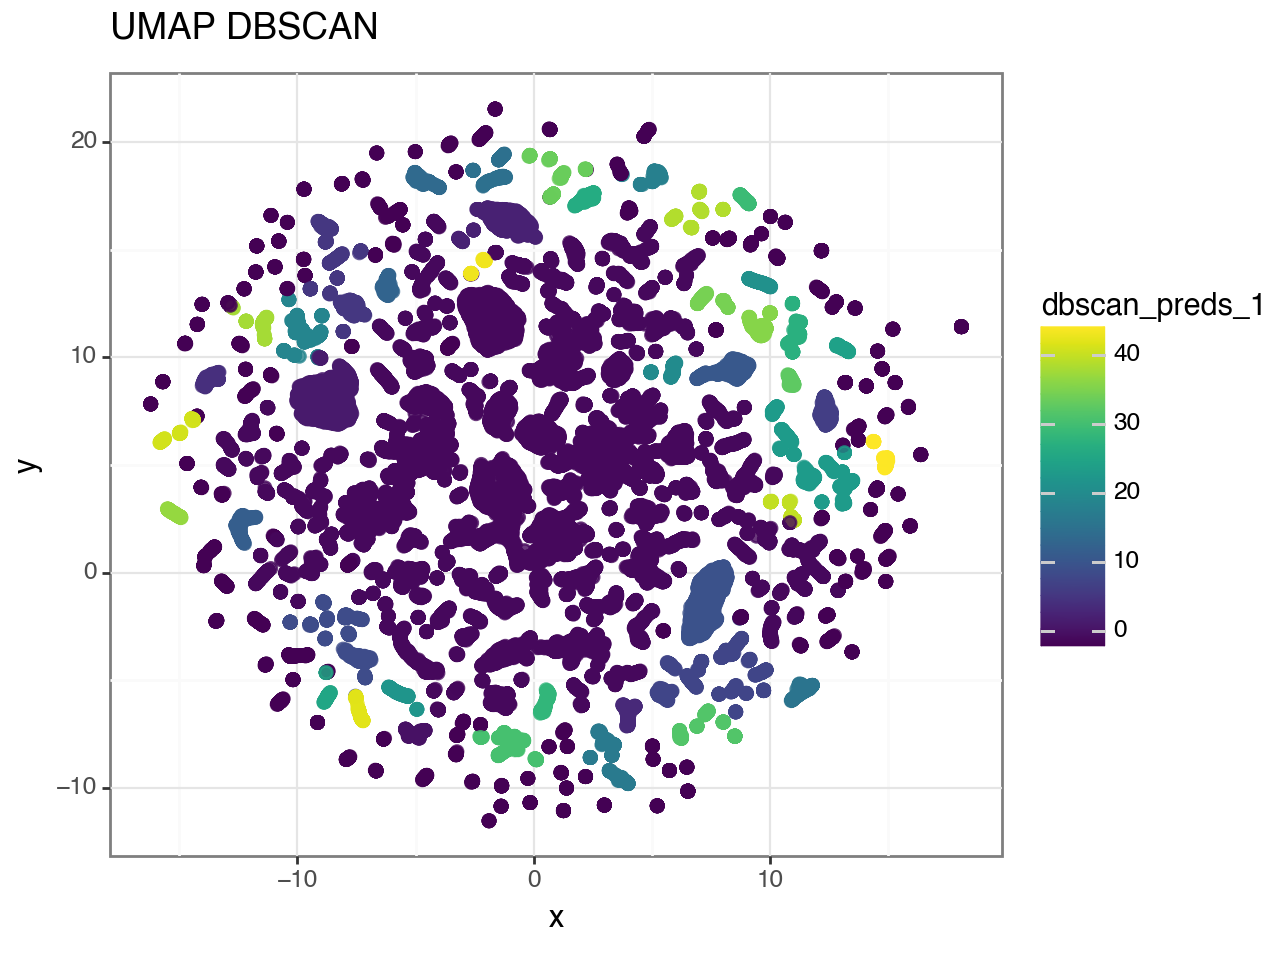

<Figure Size: (640 x 480)>

In [91]:
dbscan_clusterer_1 = DBSCAN(eps=0.95, min_samples=120).fit(umap_embedding)

dbscan_clusterer_2 = DBSCAN(eps=0.9, min_samples=150).fit(umap_embedding)

UMAP_2D_data["dbscan_preds_1"] = dbscan_clusterer_1.labels_
UMAP_2D_data["dbscan_preds_2"] = dbscan_clusterer_2.labels_

dbscan_plot_1 = (p9.ggplot(UMAP_2D_data, p9.aes(x='x', y='y', fill='dbscan_preds_1', color='dbscan_preds_1'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('UMAP DBSCAN')
      + p9.theme_bw())

dbscan_plot_2 = (p9.ggplot(UMAP_2D_data, p9.aes(x='x', y='y', fill='dbscan_preds_2', color='dbscan_preds_2'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('UMAP DBSCAN')
      + p9.theme_bw())



dbscan_plot_1

In [92]:
len(set(dbscan_clusterer_1.labels_))

45

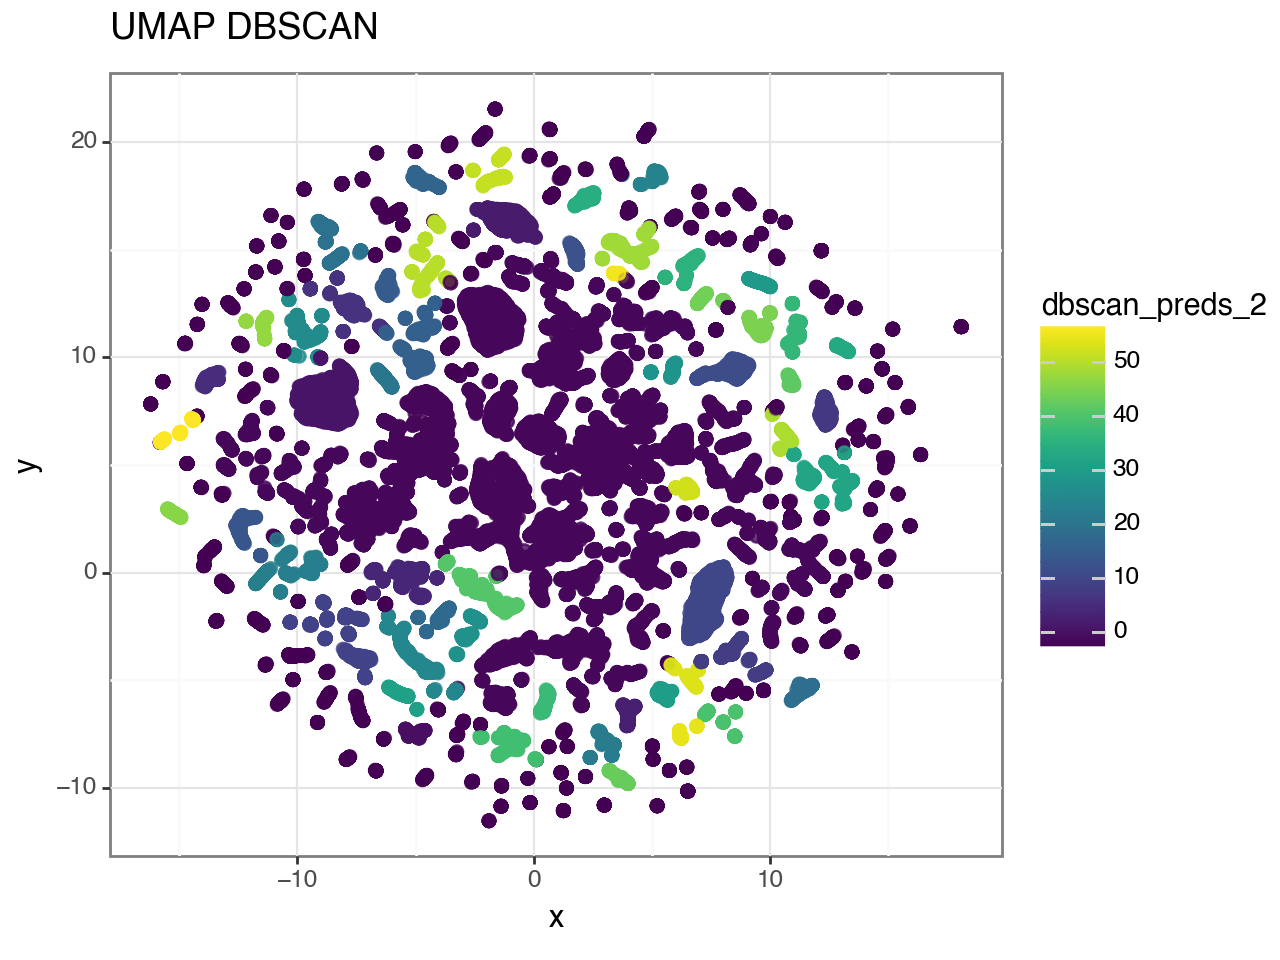

<Figure Size: (640 x 480)>

In [93]:
dbscan_plot_2

In [94]:
len(set(dbscan_clusterer_2.labels_))

57

In [85]:
embeddings.shape

(57811, 43)

In [96]:
embeddings['dbscan_cluster'] = dbscan_clusterer_2.labels_

embeddings[embeddings['dbscan_cluster'] == 0]['dbscan_cluster'].sample(5)

14786    0
44156    0
14440    0
51057    0
40579    0
Name: dbscan_cluster, dtype: int64

In [42]:
# dataset = pd.read_csv()

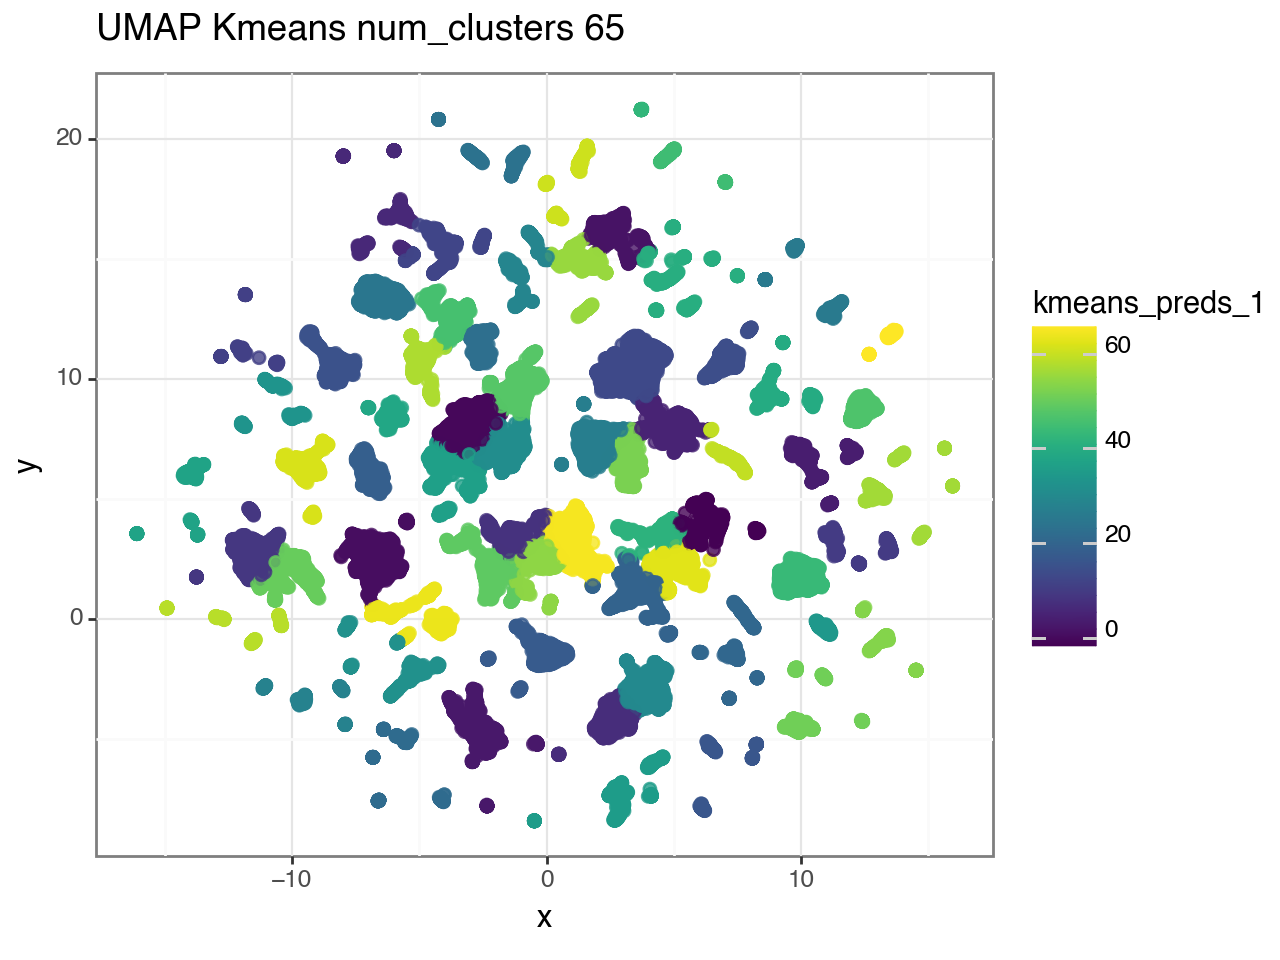

<Figure Size: (640 x 480)>

In [43]:
num_clusters_1 = 65
num_clusters_2 = 45
random_state = 32

kmeans_clusterer_1 = KMeans(n_clusters=num_clusters_1, init='k-means++',
                        verbose=0, random_state=random_state,
                        algorithm='auto').fit(umap_embedding)

kmeans_clusterer_2 = KMeans(n_clusters=num_clusters_2, init='k-means++',
                        verbose=0, random_state=random_state,
                        algorithm='auto').fit(umap_embedding)


UMAP_2D_data["kmeans_preds_1"] = kmeans_clusterer_1.labels_
UMAP_2D_data["kmeans_preds_2"] = kmeans_clusterer_2.labels_

kmeans_plot_1 = (p9.ggplot(UMAP_2D_data, p9.aes(x='x', y='y', fill='kmeans_preds_1', color='kmeans_preds_1'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle(f'UMAP Kmeans num_clusters {num_clusters_1}')
      + p9.theme_bw())

kmeans_plot_2 = (p9.ggplot(UMAP_2D_data, p9.aes(x='x', y='y', fill='kmeans_preds_2', color='kmeans_preds_2'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle(f'UMAP Kmeans num_clusters {num_clusters_2}')
      + p9.theme_bw())

kmeans_plot_1

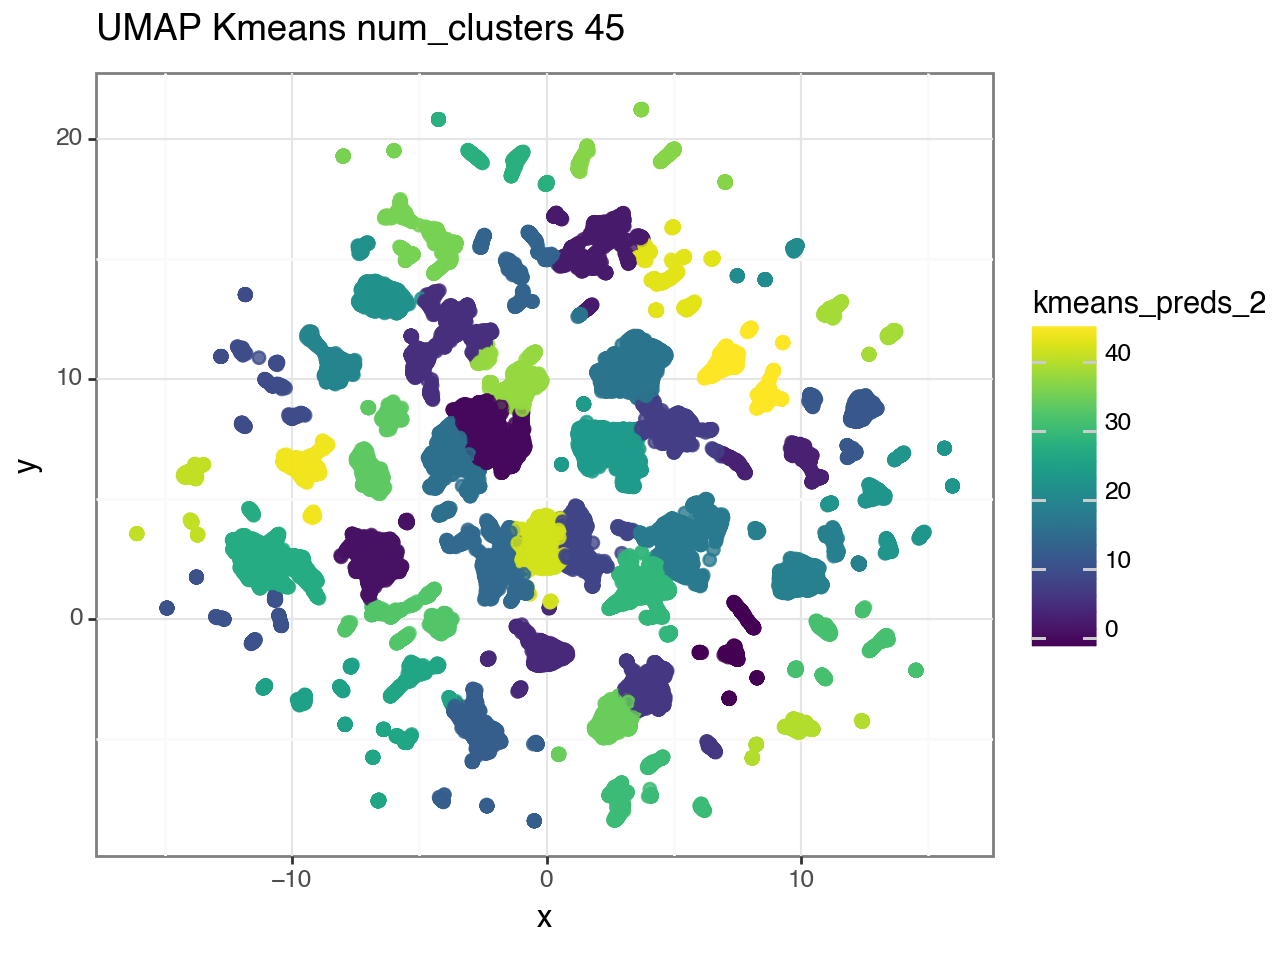

<Figure Size: (640 x 480)>

In [44]:
kmeans_plot_2

### Dimensionality Reduction with PCA

In [32]:
%%time
n_components = 10
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(dataset_scaled)

CPU times: user 19.4 s, sys: 767 ms, total: 20.2 s
Wall time: 2.77 s


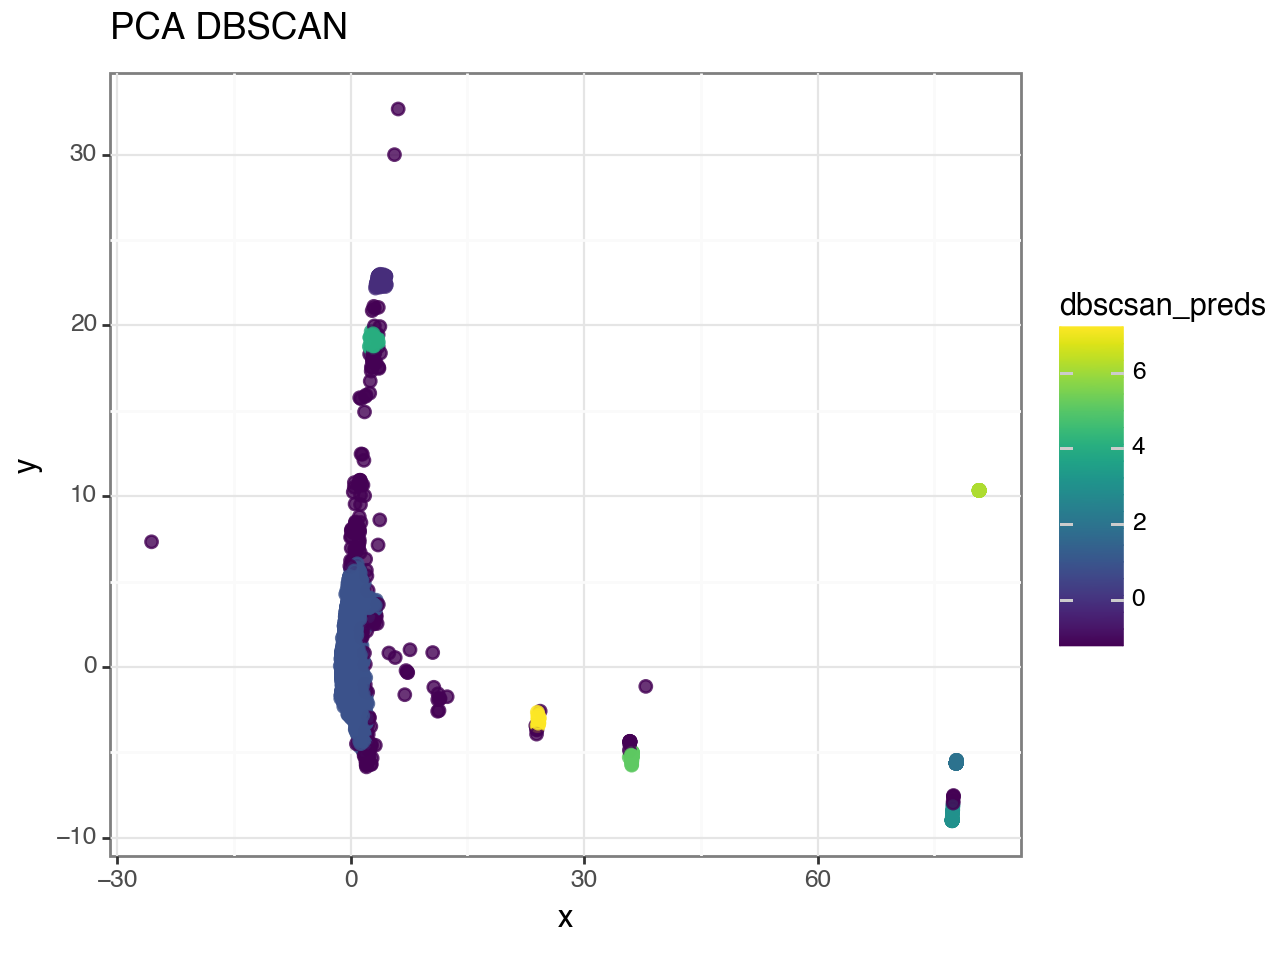

<Figure Size: (640 x 480)>

In [33]:
PCA_data = pd.DataFrame()
PCA_data['x'] = principalComponents[:,0]
PCA_data['y'] = principalComponents[:,1]

PCA_dbscan_clusterer = DBSCAN(eps=0.3, min_samples=10).fit(PCA_data)

PCA_kmeans_clusterer = KMeans(n_clusters=num_clusters_1, init='k-means++',
                        verbose=0, random_state=random_state,
                        algorithm='auto').fit(PCA_data)


PCA_data["dbscsan_preds"] = PCA_dbscan_clusterer.labels_
PCA_data["kmeans_preds"] = PCA_kmeans_clusterer.labels_

dbscan_pca = (p9.ggplot(PCA_data, p9.aes(x='x', y='y', fill='dbscsan_preds', color='dbscsan_preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('PCA DBSCAN')
      + p9.theme_bw())

kmeans_pca = (p9.ggplot(PCA_data, p9.aes(x='x', y='y', fill='kmeans_preds', color='kmeans_preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('PCA Kmeans')
      + p9.theme_bw())

dbscan_pca

In [34]:
len(set(PCA_dbscan_clusterer.labels_))

9

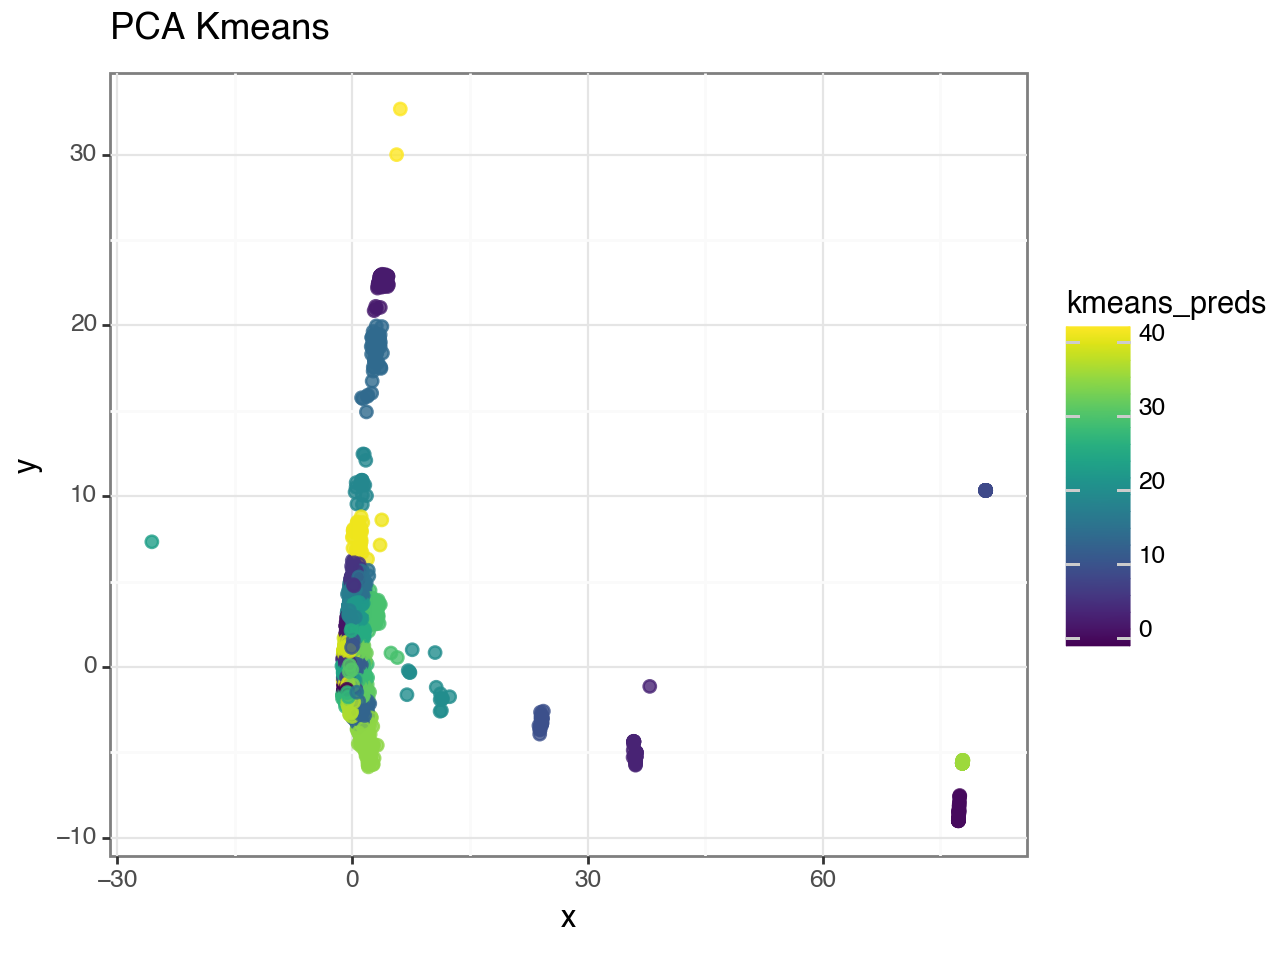

<Figure Size: (640 x 480)>

In [35]:
kmeans_pca

### KModes

In [5]:
# умеет работать с кат фичами
cat_num = pd.read_csv('../data/cat_num.csv')

In [6]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

cat_cols = cat_num.select_dtypes(include='object')
categorical_indices = column_index(cat_num, cat_cols.columns)
categorical = list(categorical_indices)

In [7]:
%%time
kproto = KModes(n_clusters=45, init='Cao', verbose=0)
clusters = kproto.fit_predict(cat_num, categorical=categorical)

CPU times: user 8min 29s, sys: 2.76 s, total: 8min 32s
Wall time: 8min 41s


In [17]:
UMAP_2D_data = pd.read_csv('../data/UMAP_2D_data.csv')
UMAP_2D_data.sample()

,x,y
34862,0.155387,0.724539


In [18]:
UMAP_2D_data["kmode_preds"] = clusters

In [20]:
kmode_plot = (p9.ggplot(UMAP_2D_data, p9.aes(x='x', y='y', fill='kmode_preds', color='kmode_preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('UMAP KModes')
      + p9.theme_bw())

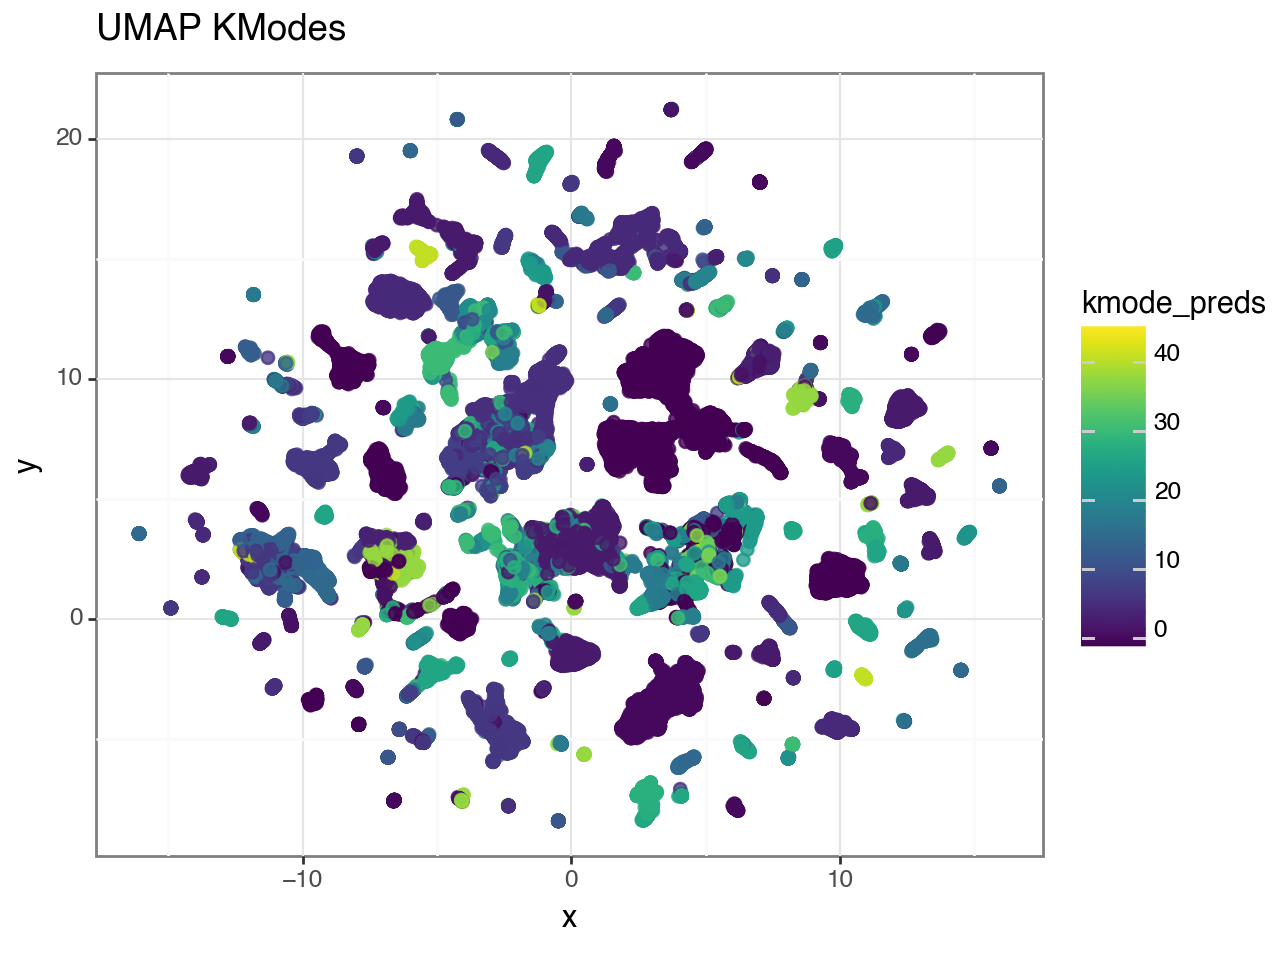

<Figure Size: (640 x 480)>

In [21]:
kmode_plot

### Gower Distance 

**не досчиталось** 🫤

In [22]:
# умеет работать с кат фичами
def calculate_gower_distance(df):
  
  '''
  Takes a dataframe as an input and returns the gower distance
  matrix.
  
  '''

  variable_distances = []
  
  for col in range(df.shape[1]):
    
    feature = df.iloc[:,[col]]
    if feature.dtypes.values == object:
      
      feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature, drop_first=True))
        
    else:
      
      feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / max(np.ptp(feature.values),1)


      variable_distances.append(feature_dist)
      

  return np.array(variable_distances).mean(0)

In [4]:
# TODO: запустить позже 

In [ ]:
%%time 
gower_data = pd.read_csv('../data/cat_num.csv')
gower_distance_matrix = calculate_gower_distance(gower_data)

In [ ]:
gower_distance_matrix

In [ ]:
%%time 
umap_embeddings = umap.UMAP(random_state=42, n_components=2).fit_transform(gower_distance_matrix)

gower_data['x'] = umap_embeddings[:,0]
gower_data['y'] = umap_embeddings[:,1]

In [ ]:
num_clusters = 42
# gower_clusterer = KMedoids(n_clusters=num_clusters, metric='precomputed',
#                            method='pam', init='build', 
#                            max_iter=300, random_state=random_state).fit(gower_distance_matrix)

gower_clusterer = KMedoids(n_clusters=num_clusters, metric='precomputed',
                           method='pam', init='build', 
                           max_iter=300, random_state=random_state).fit(gower_distance_matrix)
# kmedoids.pam(diss, medoids, max_iter=100, init='build', random_state=None)

In [ ]:
gower_data["preds"] = gower_clusterer.labels_

In [ ]:
gower_d = (p9.ggplot(gower_data, p9.aes(x='x', y='y', fill='preds', color='preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Gower Matrix UMAP 2D KMedoids')
      + p9.theme_bw())

gower_d